# Assignment 5:

In this assignment, I have to do the following:
- Use pretrained RESNET 18 model and train on CIFAR10
- Get a list of 50 misclassified images
- Create a gallery of Gradcam results

## Import all the Keras libraries 

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout,  GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


## Mount the google drive to save the model

In [2]:
 # Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Load the  train features, train labels, test features, train labels from CIFAR10 dataset 

In [3]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 9s 0us/step


## Define class names and display
* Define the 10 classes as airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
* Display one element from each class

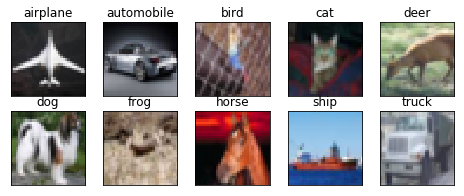

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

## Define a method for diplaying model history
Define a method plot_model_history for displaying model history which will do the following
* Plot Model accuracy (both the training and validation accuracy) vs number of epochs. 
* Model loss ((both the training and validation accuracy) vs number of epoch

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

## Define a method for calculate accuracy

Define a mehod accuracy which will calculate accuracy from model
* Get True class
* Get Predicted class
* Get numbe of correc predictions
* Divide number of correct predictions by total number of elements to get the accuracy

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

## Perform pixel normalization of features and one hot encoding of train and test

* Perform pixel normalization by dividing train and test features by 255
* Use to_categorical method of np_utils to use one hot encoding to Convert the train_labels, test_labels to 10 dimensional categorical matrix

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [8]:
test_features.shape

(10000, 32, 32, 3)

## Install RESNET18 pretrained model
- Install RESNET18 pretrainded model on Imagenet from https://github.com/qubvel/classification_models.git

In [9]:
!pip install git+https://github.com/qubvel/classification_models.git


  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-a3_07m53
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-a3_07m53
  Running command git submodule update --init --recursive -q
  Stored in directory: /tmp/pip-ephem-wheel-cache-qisv_33c/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers


## Use Transfer Learning to use pretrained model to work on CIFAR10

Since pretrained model is trained on imagenet butI need to use model to work on CIFAR10.I will do the following steps below to chnage the model work on CIFAR10


* Load the base model fro RESNET18 pretrained on imagenet without top with inpuce share chnaged to dimensions 32x32x32
* Add 1x1 convolution with 10 filters which is the number of classes for CIFAR10
* Add Global Average Pooling Layer
* Add softmax activation layer
* Get the New model

In [10]:
from classification_models.resnet import ResNet18, preprocess_input
from keras.models import Model, load_model
from keras.layers import Activation, Flatten, Dense, Dropout, Input, Concatenate, GlobalAveragePooling2D
num_classes = 10

# build model
base_model = ResNet18(input_shape=(32,32,3), weights='imagenet', include_top=False)
x = Convolution2D(num_classes, 1, 1, use_bias=False, name='custom_1_1_layer')(base_model.output) 
x = GlobalAveragePooling2D(name='custom_global_average_pooling')(x)
output = Activation('softmax', name='custom_softmax')(x)
model = Model(inputs=[base_model.input], outputs=[output])


W0712 02:05:28.507779 140014522099584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0712 02:05:28.550945 140014522099584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0712 02:05:28.552329 140014522099584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0712 02:05:28.553640 140014522099584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0712 02:05:28.554909 140014

44924928/44920640 [==============================] - 3s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1), use_bias=False, name="custom_1_1_layer")`
  


## Summarize the model

In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

## Visually Display the Model Architecture

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

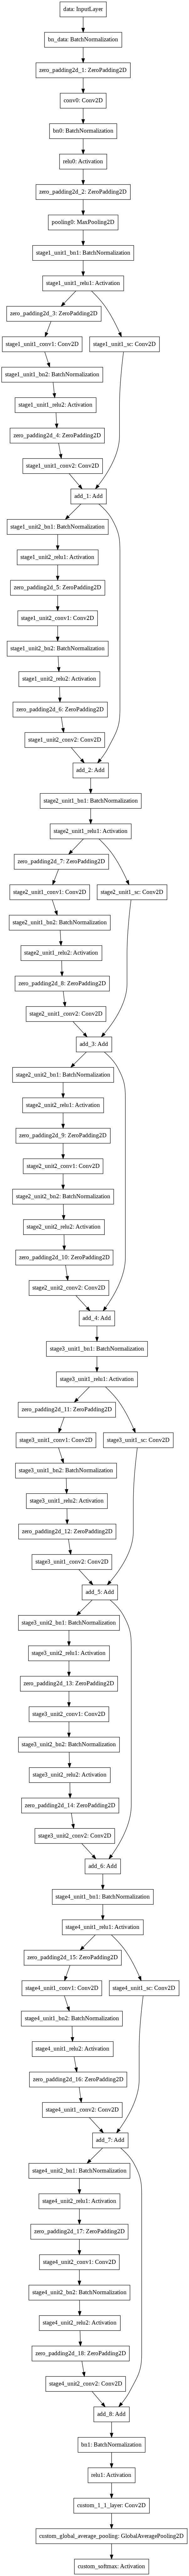

In [13]:
from IPython.display import Image
Image(filename='model.png')

## Compile the Model

In [14]:
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

W0712 02:05:59.002302 140014522099584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



## Train the  Model and get the Metrics (Accuracy, Loss) and Plot the model history

 * Train the model using fit_generator method
 * Plot the model history



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`
W0712 02:06:05.463668 140014522099584 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a futur

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


390/390 [==============================] - 22s 56ms/step - loss: 1.1854 - acc: 0.5938 - val_loss: 0.9052 - val_acc: 0.6894

Epoch 00001: val_acc improved from -inf to 0.68940, saving model to /content/drive/My Drive/assignment_5_resnet_cifar10.h5
Epoch 2/100
390/390 [==============================] - 17s 43ms/step - loss: 0.7337 - acc: 0.7441 - val_loss: 0.7539 - val_acc: 0.7451

Epoch 00002: val_acc improved from 0.68940 to 0.74510, saving model to /content/drive/My Drive/assignment_5_resnet_cifar10.h5
Epoch 3/100
390/390 [==============================] - 16s 42ms/step - loss: 0.5734 - acc: 0.8010 - val_loss: 0.7268 - val_acc: 0.7568

Epoch 00003: val_acc improved from 0.74510 to 0.75680, saving model to /content/drive/My Drive/assignment_5_resnet_cifar10.h5
Epoch 4/100
390/390 [==============================] - 16s 42ms/step - loss: 0.4565 - acc: 0.8411 - val_loss: 0.7089 - val_acc: 0.7704

Epoch 00004: val_acc improved from 0.75680 to 0.77040, saving model to /content/drive/My Driv

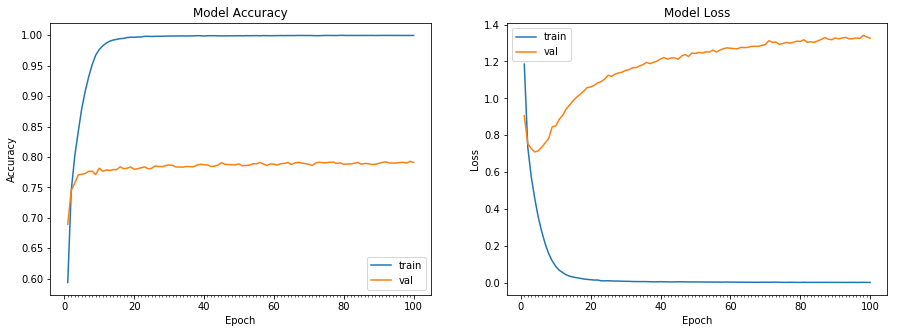

Accuracy on test data is: 79.11


In [15]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.models import load_model



datagen = ImageDataGenerator(zoom_range=0.0,horizontal_flip=False, featurewise_center=True, featurewise_std_normalization=True)

callbacks_list=[]
model_save_path= "/content/drive/My Drive/assignment_5_resnet_cifar10.h5"
callbacks_list.append(ModelCheckpoint(model_save_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max'))


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1, callbacks=callbacks_list)

end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

## Get the validation accuracy of Best  model

In [17]:
from keras.models import load_model

# Load the best model
model_save_path= "/content/drive/My Drive/assignment_5_resnet_cifar10.h5"
best_model = load_model(model_save_path)

# compute test accuracy on best model
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, best_model))


Accuracy on test data is: 79.28


## Create a pandas dataframe which will have true class index and predicted class index

In [0]:
import pandas as pd


result = best_model.predict(test_features)
predicted_class = np.argmax(result, axis=1)
true_class = np.argmax(test_labels, axis=1)


df = pd.DataFrame({ "true_class": true_class, "predicted_class": predicted_class })     

In [19]:
df

,true_class,predicted_class
0,3,3
1,8,8
2,8,8
3,0,8
4,6,6
5,6,6
6,1,1
7,6,6
8,3,3
9,1,1


## Find the misclassified images

 *   Apply query on data pandas dataframe df and get a new dataframe of misclassified images.
  * Display the number of misclassified imags

In [0]:
misclassified_df = df[df["true_class"] != df["predicted_class"]]

In [21]:
misclassified_df.shape

(2072, 2)

In [22]:
print("Total number of misclassifeid images: " + str(misclassified_df.shape[0]))

Total number of misclassifeid images: 2072


## Observation
As number of misclassified images are 2072 which matches with Validation accuracy of 79.28 which should give  2072 misclassified images

## Display the list of 50 misclassified images

- From the misclassified dataframe get list of 50 records
- Display the images with labeling wach image with Actual Class name and Predicted class name

In [0]:
# Created a dataframe misclassified_display_df of  25 misclassified 
misclassified_display_df = misclassified_df.head(50)

In [0]:
# Import matplotlib library
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

In [27]:
# Get the dimension for X_test
test_features.shape

(10000, 32, 32, 3)

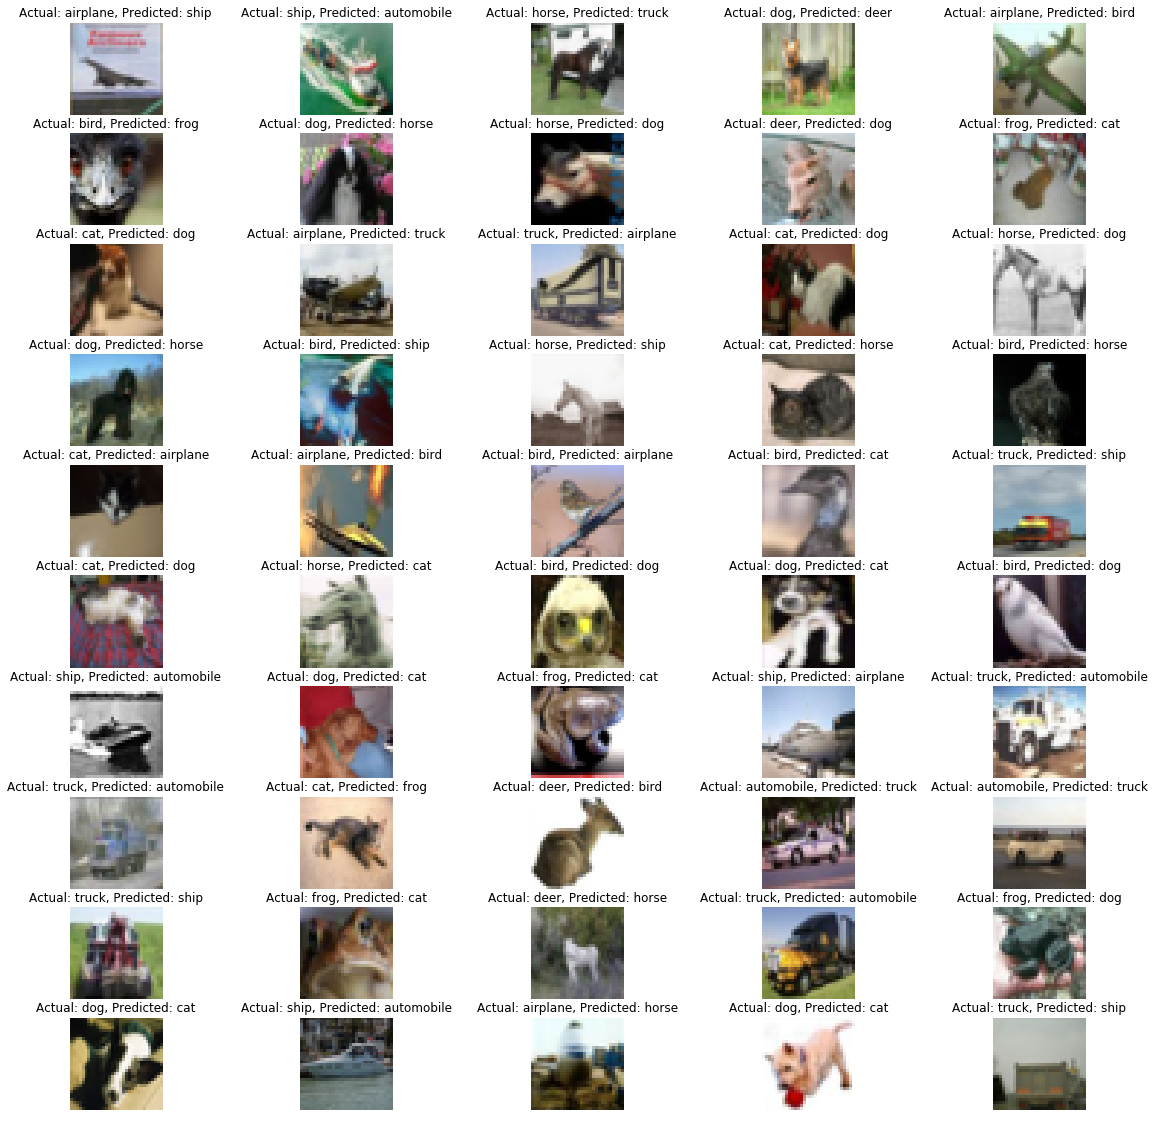

In [28]:
display_test_features = test_features

plt.figure(figsize=(20,20))
columns = 5
i= 0
# Display the list of 50 misclassified images
for index, row in misclassified_df.iterrows() :
    ax = plt.subplot(10, 5, i+1)
    ax.set_title("Actual: " + str(class_names[row["true_class"]]) + ", Predicted: " + str(class_names[row["predicted_class"]]))
    ax.axis('off')
    img= display_test_features[index]
    plt.imshow(img)
    i +=1
    if i==50:
        break

In [29]:
misclassified_display_df.index

Int64Index([  3,  15,  20,  24,  27,  35,  42,  57,  58,  59,  61,  74,  76,
             78,  83,  85,  86,  87, 115, 118, 121, 125, 129, 135, 139, 143,
            145, 147, 148, 149, 150, 158, 162, 164, 170, 172, 184, 188, 193,
            201, 213, 221, 223, 225, 229, 232, 233, 237, 238, 247],
           dtype='int64')

## Define a method for GRADCAM
Define a method get_gradcam_image which will take the pixel normalized image, model, layer name and return the gradcam image

The steps are as below:
* Import OpenCV library cv2
* Use expand_dims to convert image to a batch of size 1
*  Get the predictions for the input image
* Take the topmost class index
* Take output from the given convolution layer
*  Compute the gradient of the class output value with respect to the feature map
*  Pool the gradients over all the axies leaving out the channel dimension
* Weigh the output feature map with the computed gradient values
*  Average the weighted feature map along the channel dimension resulting in a heatmap of first two dimensions equal to original image first two dimensions
*  Normalize the heat map to make the values between 0 and 1
* Multiply the pixel values of original image by 255
* Use addWeighted method of cv2 by giving the scaled input image and the heat map at 50% basis to create the superimposed image








In [0]:
import cv2

def get_gradcam_image(orig_std_image, model, layer_name):
  
  x = np.expand_dims(orig_std_image, axis=0)
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = best_model.output[:, class_idx]
  conv_layer = best_model.get_layer(layer_name)


  grads = K.gradients(class_output, conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([best_model.input], [pooled_grads, conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  
  no_of_channels = conv_layer.get_weights()[0].shape[-1]
  for i in range(no_of_channels):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 1e-7)
  heatmap /= np.max(heatmap)

 
  heatmap = cv2.resize(heatmap, (orig_std_image.shape[1], orig_std_image.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)



  orig_image= np.uint8(255 * (orig_std_image))

  superimposed_img = cv2.addWeighted(orig_image, 0.5, heatmap, 0.5, 0)
  return superimposed_img

## Display GRADCAM results on layer stage2_unit2_conv2 for 50 misclassified images

* Iterate over 50 records misclassified test image dataframe
* For each misclassified test image record, get the original image
* Use get_gradcam_image by passing input as original test image, best model, layer as stage2_unit2_conv2 to get teh superimosed image
* In each row display first the original image followed by gradcam image

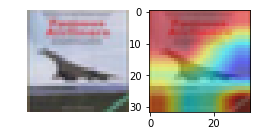

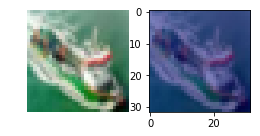

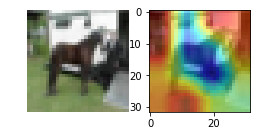

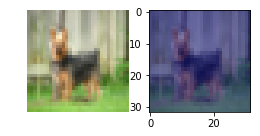

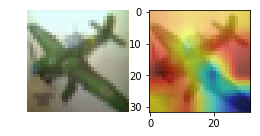

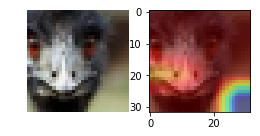

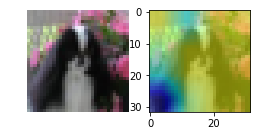

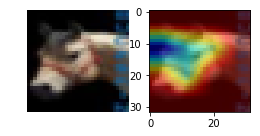

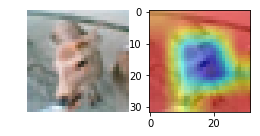

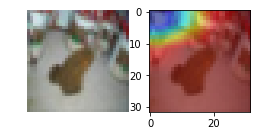

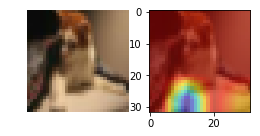

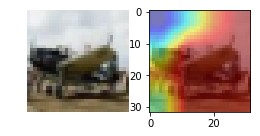

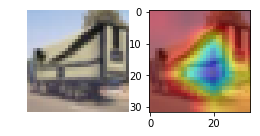

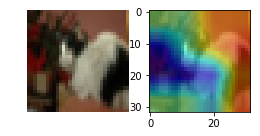

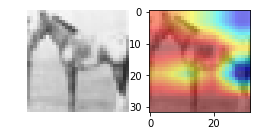

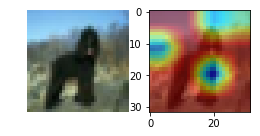

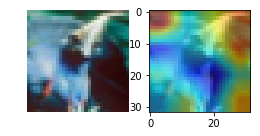

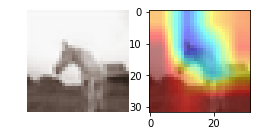

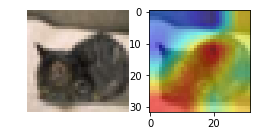

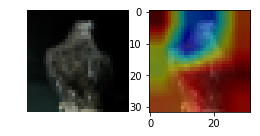

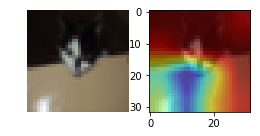

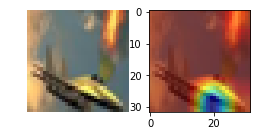

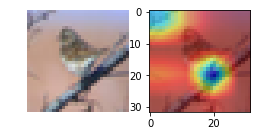

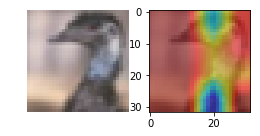

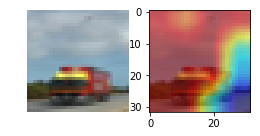

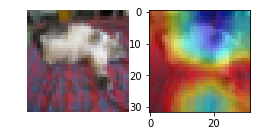

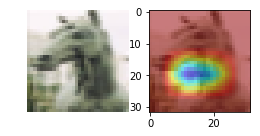

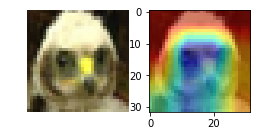

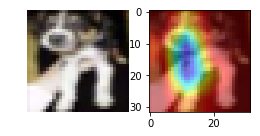

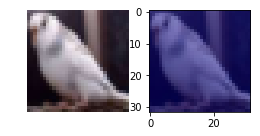

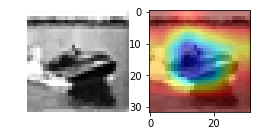

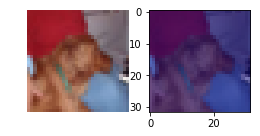

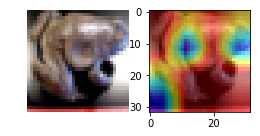

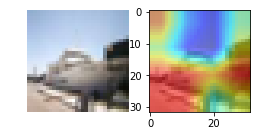

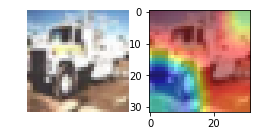

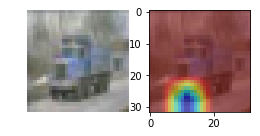

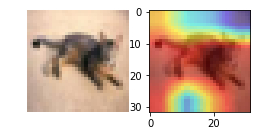

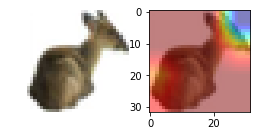

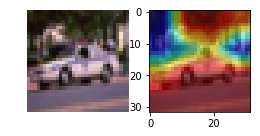

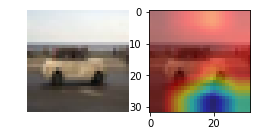

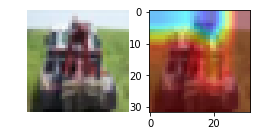

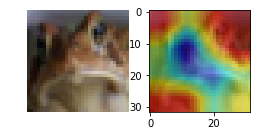

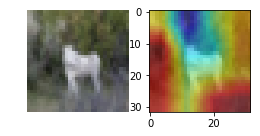

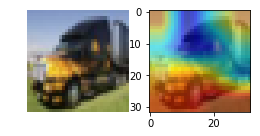

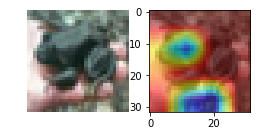

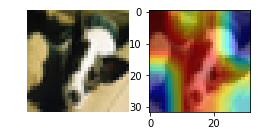

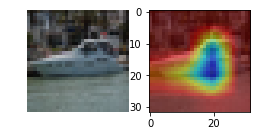

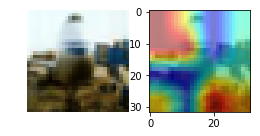

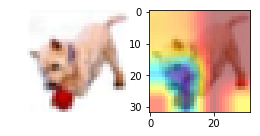

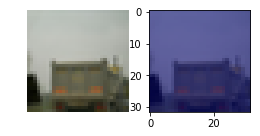

In [34]:
actual_labels = np.argmax(test_labels, axis=1)

for i in misclassified_display_df.index :
  test_image = test_features[i]
  superimposed_img = get_gradcam_image(test_image, best_model, "stage2_unit2_conv2")

  fig=plt.figure(figsize=(4, 4))
  columns = 2
  rows = 1
  ax = fig.add_subplot(rows, columns, 1)
  ax.axis('off')
  plt.imshow(test_image)
  fig.add_subplot(rows, columns, 2)
  ax.axis('off')
  plt.imshow(superimposed_img)
  plt.show()
    

## Final Observations:

In this assignment:

- I have first loaded a pretrained RESNET18 model on imagenet
- Use transfer learning to trai nthe model on CIFAR 10 dataset
- Got a accuracy of 79.28 on the model
- Get a list of 50 misclassified images and create a galary
- Get GRADCAM on the misclassified images and create a gallery by showing original image and GRADCAM result in each row


